In [17]:
library(ggplot2)
library(dplyr)
library(gplots)
library(reshape2)
library(umap)
library(patchwork)
library(ggExtra) 
library(pals)
library(RColorBrewer)
library(ComplexHeatmap)
library(circlize)

In [18]:
filtered <- read.table("../20230101_QC/final_summary_anno3.txt",header=T,sep="\t")
variant_list <- read.table("../variant_annotation/780_variant_annotation_COUPTF2_TBR1_DLX1_CBH.csv",header=T,sep=",",row.names=1)

# Bulk

In [ ]:
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] 
#shared_variant_list<-variant_list[variant_list$sample_number_presented>1,]
#shared_variant_list<-variant_list[variant_list$TBR_BR_sort==1,] # cortex only shared variant annotation table
#shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(shared_variant_list),]
# brain_only_shared_mosaic_filtered<-shared_mosaic_filtered[shared_mosaic_filtered$CHROM.POS.REF.ALT %in% shared_variant_list[shared_variant_list$CTX_only=='1',]$variant_list,]
# output: shared/validated variant's MAF with sample and other annotation.

In [ ]:
# taking a subset of samples
melt_mtcars<-mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region","Bulk_main", "Sort_main","CTX_BG_HIP_relationship", "Cell_Type","Note")]
melt_mtcars<-melt_mtcars[melt_mtcars$Bulk_main==1,]
#melt_mtcars<-melt_mtcars[melt_mtcars$ID %in% c('7614-L-9-Ins-COUPTF2','7614-L-9-Ins-DLX1','7614-L-9-Ins-TBR1','7614-L-O-COUPTF2','7614-L-O-DLX1','7614-L-O-TBR1',
#                                              '7614-L-T-COUPTF2','7614-L-T-DLX1','7614-L-T-TBR1','7614-R-5-Ins-COUPTF2','7614-R-5-Ins-DLX1','7614-R-5-Ins-TBR1',
#                                               '7614-R-F-COUPTF2','7614-R-F-DLX1','7614-R-F-TBR1','7614-R-O-COUPTF2','7614-R-O-DLX1','7614-R-O-TBR1',
#                                               '7614-R-T-COUPTF2','7614-R-T-DLX1','7614-R-T-TBR1'),]
#melt_mtcars<-melt_mtcars[!melt_mtcars$ID %in% c('JGG','JGG-bulk','JGG-sorted'),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('COUPTF2'),]
# melt_mtcars<-melt_mtcars[melt_mtcars$Hemisphere %in% c('L'),]
# melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX','BG','AMG','HIP','THAL','SUB','CLO','CB','Kidney','Liver')),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Note %in% c('SMALL'),]

#melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('Bulk'),]
#melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX','BG')),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Region %in% c('P','T','O','Ins','PF','F'),]
#melt_mtcars<-melt_mtcars[melt_mtcars$Punch %in% c('1'),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)
nrow(melt_mtcars)

In [ ]:
#dcasting with labeling
casted_MAF_VarBySample <- dcast(melt_mtcars, ID~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID # change rownames to ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1] # remove ID column
nrow(casted_MAF_VarBySample2) # row number 

In [11]:
#remove labeling from dcasted matrix
casted_MAF_VarBySample3<-na.omit(t(casted_MAF_VarBySample2)) # Sample by variant matrix with sqrt-MAF values
var_anno<-variant_list[variant_list$variant_list %in% rownames(casted_MAF_VarBySample3),] # take variant annotation from the variants in casted_MAF_VarBySample3
casted_MAF_VarBySample3<-casted_MAF_VarBySample3[order(rownames(casted_MAF_VarBySample3)), ] # rearrange the casted_MAF_VarBySample3 matrix in order of variant name
var_anno<-var_anno[order(row.names(var_anno)), ] # rearrange the var_anno in order of variant name
casted_MAF_VarBySample3 <- cbind(casted_MAF_VarBySample3,var_anno)

In [12]:
label<-casted_MAF_VarBySample3[which(names(casted_MAF_VarBySample3)=='variant_list'):ncol(casted_MAF_VarBySample3)]

In [13]:
df1<-casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)]
print(paste("nrows before filtering :",nrow(df1)))
# Remove variants with zero values in all samples
all_zero_row_in_df1<-df1[rowSums(df1 != 0) == 0, ]
label<-label[!label$variant_list %in% rownames(all_zero_row_in_df1),]
df1<-df1[rowSums(df1 != 0) > 0, ]
df1_cor<-cor(t(df1),method = "pearson", use="pairwise.complete.obs")
print(paste("removed rows due to zero values in all column :",nrow(all_zero_row_in_df1)))
print(paste("remaining rows :",nrow(df1)))
myCol<-as.data.frame(label[,])

[1] "nrows before filtering : 780"
[1] "removed rows due to zero values in all column : 0"
[1] "remaining rows : 780"


In [14]:
Colors = c("blue","white","red")
Colors = colorRampPalette(Colors)(100)

In [15]:
LR_colors = colorRamp2(c(-1, 0, 1), c("#d68426", "#ffffff", "#2a1abf"))
left_right_cell_col_ann = HeatmapAnnotation(simple_anno_size = unit(0.2, "cm"), 
                                        which = "row", 
                                        annotation_name_gp = gpar(fontsize = 4),
                                        Bulk = myCol$Bulk,
                                        ADRENAL = myCol$ADRENAL,
                                        HEART = myCol$HEART,
                                        LIVER = myCol$LIVER,
                                        KIDNEY = myCol$KIDNEY,
                                        SKIN = myCol$SKIN,
                                        Brain_only = myCol$Brain_only,
                                        CB = myCol$CB,
                                        CTX = myCol$CTX,
                                        POA = myCol$POA,
                                        BG = myCol$BG,
                                        THAL = myCol$THAL,
                                        HIP = myCol$HIP,
                                        OLF = myCol$OLF,
                                        CTX_only = myCol$CTX_only,
                                        CTX_BG_only = myCol$CTX_BG_only,
                                        BG_only = myCol$BG_only,
                                        THAL_only = myCol$THAL_only,
                                        L = myCol$L,
                                        R = myCol$R,
                                        LR_only = myCol$Left_only - myCol$Right_only, 
                                        NeuN = myCol$NeuN,
                                        IN_only = myCol$IN_only,
                                        COUPTF2 = myCol$COUPTF2,
                                        COUP_only = myCol$COUP_only,
                                        TBR1 = myCol$TBR1,
                                        TBR_only = myCol$TBR_only,
                                        TBR_BR = myCol$TBR_BR,
                                        DLX1 = myCol$DLX1,
                                        DLX_BR = myCol$DLX_BR,
                                        col = list(LR_only = LR_colors,
                                        COUP_only = colorRamp2(c(0, 1), c("#ffffff", "black")),
                                        IN_only = colorRamp2(c(0, 1), c("#ffffff", "darkgreen")),
                                        TBR_only = colorRamp2(c(0, 1), c("#ffffff", "purple")), 
                                        TBR_BR = colorRamp2(c(0, 1), c("#ffffff", "#e58f9d")),
                                        DLX_BR = colorRamp2(c(0, 1), c("#ffffff", "maroon"))))#,
                                        #annotation_legend_param = legendDets) 

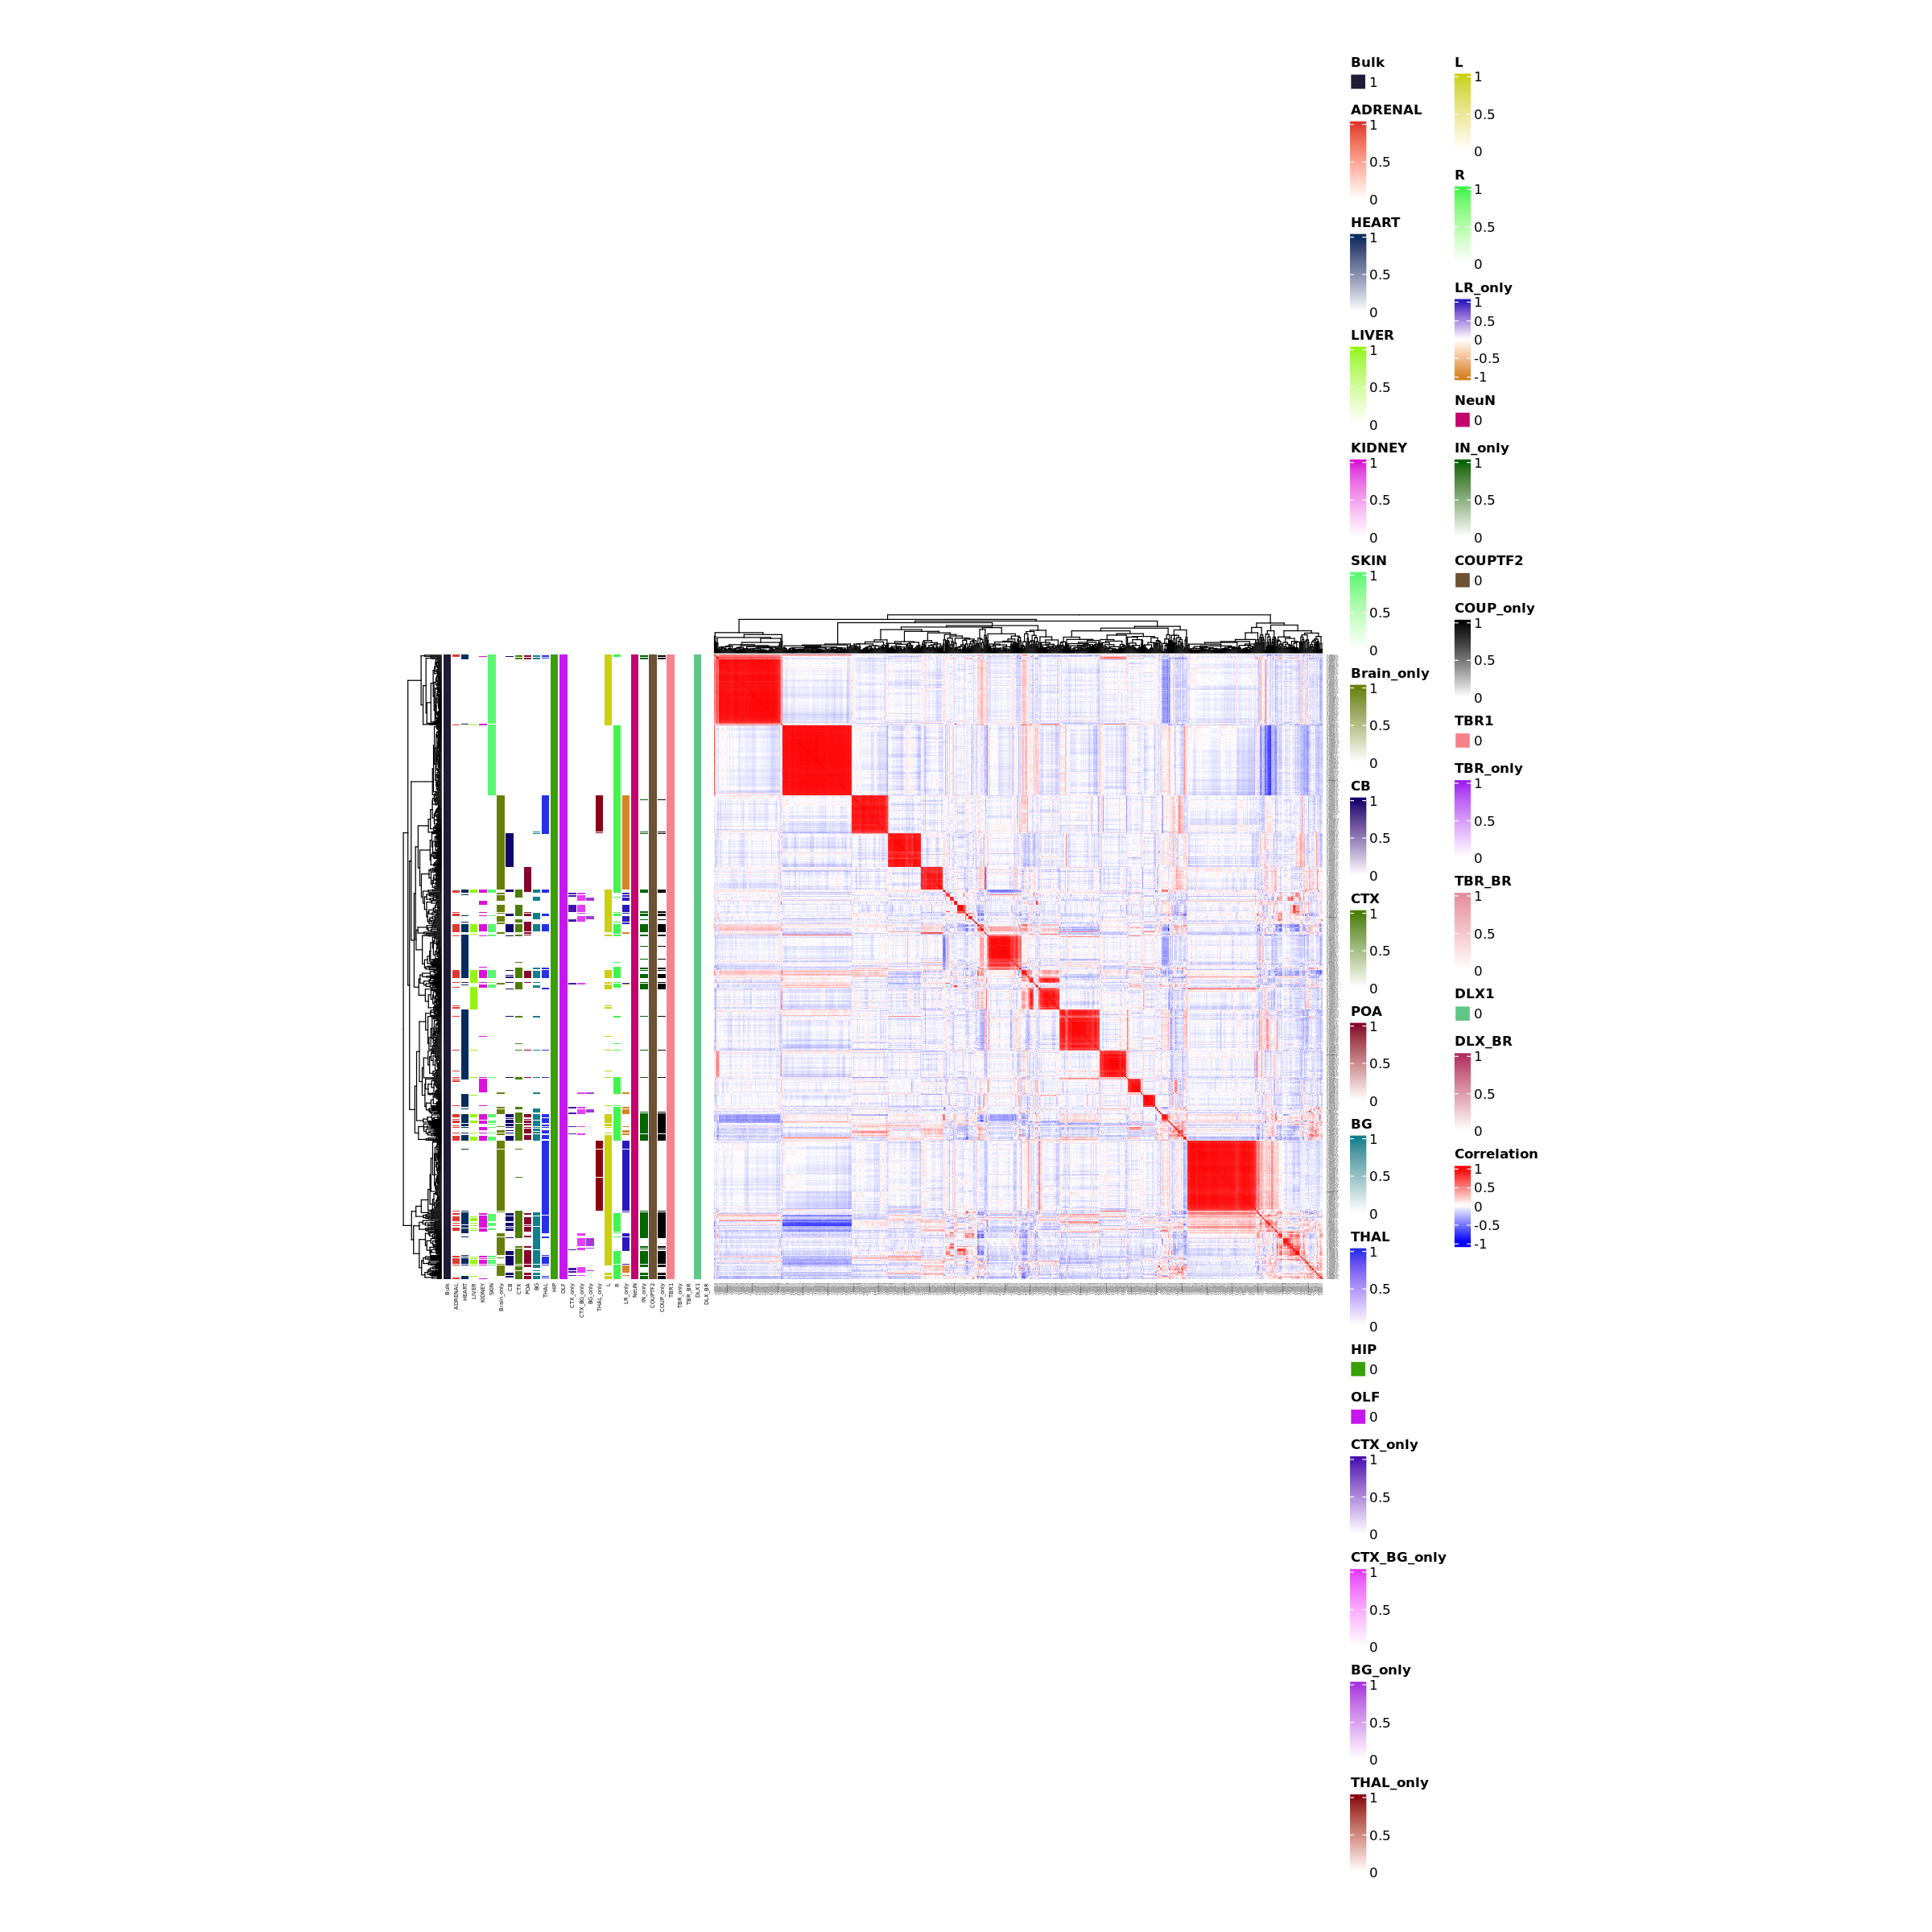

In [16]:
options(repr.plot.width=20, repr.plot.height=20)

complexheatmap <- Heatmap(df1_cor,
        col = Colors,
        row_names_gp = gpar(fontsize = "1"), column_names_gp = gpar(fontsize = "1"), name = "Correlation",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(16, "cm"),
        heatmap_height = unit(18, "cm")) 
complexheatmap

In [17]:
pdf(file="../VarXVar_plots/7669_VarByVar_Bulk_780_All_Var.pdf",width=40,height=40)
complexheatmap
dev.off()

png 
  2

# COUPTF2

In [187]:
filtered$Punch<-as.character(filtered$Punch)
filtered$Note<-as.character(filtered$Note)

In [188]:
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] 
shared_variant_list<-variant_list[variant_list$sample_number_presented>1,]
shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(shared_variant_list),]

In [189]:
# taking a subset of samples
melt_mtcars<-shared_mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region","Bulk_main", "Sort_main","CTX_BG_HIP_relationship", "Cell_Type","Note")]
melt_mtcars<-melt_mtcars[melt_mtcars$Sort_main==1,]
melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('COUPTF2'),]
melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX')),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)
nrow(melt_mtcars)

[1] 2976

In [190]:
#dcasting with labeling
casted_MAF_VarBySample <- dcast(melt_mtcars, ID~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID # change rownames to ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1] # remove ID column
nrow(casted_MAF_VarBySample2) # row number 

[1] 16

In [191]:
#remove labeling from dcasted matrix
casted_MAF_VarBySample3<-na.omit(t(casted_MAF_VarBySample2)) # Sample by variant matrix with sqrt-MAF values
var_anno<-variant_list[variant_list$variant_list %in% rownames(casted_MAF_VarBySample3),] # take variant annotation from the variants in casted_MAF_VarBySample3
casted_MAF_VarBySample3<-casted_MAF_VarBySample3[order(rownames(casted_MAF_VarBySample3)), ] # rearrange the casted_MAF_VarBySample3 matrix in order of variant name
var_anno<-var_anno[order(row.names(var_anno)), ] # rearrange the var_anno in order of variant name
casted_MAF_VarBySample3 <- cbind(casted_MAF_VarBySample3,var_anno)

In [192]:
label<-casted_MAF_VarBySample3[which(names(casted_MAF_VarBySample3)=='variant_list'):ncol(casted_MAF_VarBySample3)]

In [193]:
df1<-casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)]
print(paste("nrows before filtering :",nrow(df1)))
# Remove variants with zero values in all samples
all_zero_row_in_df1<-df1[rowSums(df1 != 0) == 0, ]
label<-label[!label$variant_list %in% rownames(all_zero_row_in_df1),]
df1<-df1[rowSums(df1 != 0) > 0, ]
df1_cor<-cor(t(df1),method = "pearson")
print(paste("removed rows due to zero values in all column :",nrow(all_zero_row_in_df1)))
print(paste("remaining rows :",nrow(df1)))
myCol<-as.data.frame(label[,])

[1] "nrows before filtering : 186"
[1] "removed rows due to zero values in all column : 1"
[1] "remaining rows : 185"


In [194]:
LR_colors = colorRamp2(c(-1, 0, 1), c("#d68426", "#ffffff", "#2a1abf"))
Colors = c("blue","white","red")
Colors = colorRampPalette(Colors)(100)

In [195]:
names(myCol)

[1] "variant_list"                    "sample_number_presented"        
  [3] "HEART"                           "ADRENAL"                        
  [5] "CB"                              "CTX"                            
  [7] "LIVER"                           "KIDNEY"                         
  [9] "POA"                             "BG"                             
 [11] "THAL"                            "SKIN"                           
 [13] "OLF"                             "HIP"                            
 [15] "L"                               "R"                              
 [17] "I"                               "F"                              
 [19] "P"                               "O"                              
 [21] "T"                               "Cau"                            
 [23] "Put"                             "Thal"                           
 [25] "GP"                              "Hip"                            
 [27] "EC"                              "Olf"                            
 [29] "CC"                              "mO"                             
 [31] "Cb"                              "DLX1"                           
 [33] "TBR1"                            "COUPTF2"                        
 [35] "Bulk"                            "NeuN"                           
 [37] "Brain_only"                      "CTX_only"                       
 [39] "BG_only"                         "THAL_only"                      
 [41] "CTX_BG_only"                     "CTX_BG_shared"                  
 [43] "CTX_THAL_shared"                 "Left_only"                      
 [45] "Right_only"                      "sample_number_presented_COUPTF2"
 [47] "HEART_COUPTF2"                   "ADRENAL_COUPTF2"                
 [49] "CB_COUPTF2"                      "CTX_COUPTF2"                    
 [51] "LIVER_COUPTF2"                   "KIDNEY_COUPTF2"                 
 [53] "POA_COUPTF2"                     "BG_COUPTF2"                     
 [55] "THAL_COUPTF2"                    "SKIN_COUPTF2"                   
 [57] "OLF_COUPTF2"                     "HIP_COUPTF2"                    
 [59] "L_COUPTF2"                       "R_COUPTF2"                      
 [61] "I_COUPTF2"                       "F_COUPTF2"                      
 [63] "P_COUPTF2"                       "O_COUPTF2"                      
 [65] "T_COUPTF2"                       "Cau_COUPTF2"                    
 [67] "Put_COUPTF2"                     "Thal_COUPTF2"                   
 [69] "GP_COUPTF2"                      "Hip_COUPTF2"                    
 [71] "EC_COUPTF2"                      "Olf_COUPTF2"                    
 [73] "CC_COUPTF2"                      "mO_COUPTF2"                     
 [75] "Cb_COUPTF2"                      "DLX1_COUPTF2"                   
 [77] "TBR1_COUPTF2"                    "COUPTF2_COUPTF2"                
 [79] "Bulk_COUPTF2"                    "NeuN_COUPTF2"                   
 [81] "Brain_only_COUPTF2"              "CTX_only_COUPTF2"               
 [83] "BG_only_COUPTF2"                 "THAL_only_COUPTF2"              
 [85] "CTX_BG_only_COUPTF2"             "CTX_BG_shared_COUPTF2"          
 [87] "CTX_THAL_shared_COUPTF2"         "Left_only_COUPTF2"              
 [89] "Right_only_COUPTF2"              "IN_only_COUPTF2"                
 [91] "COUP_only_COUPTF2"               "TBR_only_COUPTF2"               
 [93] "TBR_BR_COUPTF2"                  "DLX_BR_COUPTF2"                 
 [95] "sample_number_presented_TBR1"    "CTX_TBR1"                       
 [97] "HIP_TBR1"                        "L_TBR1"                         
 [99] "R_TBR1"                          "I_TBR1"                         
[101] "F_TBR1"                          "P_TBR1"                         
[103] "O_TBR1"                          "T_TBR1"                         
[105] "Hip_TBR1"                        "CTX_only_TBR1"                  
[107] "HIP_only_TBR1"                   "Left_only_TBR1"                 
[109] 

In [196]:
LR_colors = colorRamp2(c(-1, 0, 1), c("#FF0000", "#ffffff", "#0000FF"))
color_list = list(LR_ONLY = LR_colors,
                  HEART = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  LIVER = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  KIDNEY = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  ADRENAL = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  SKIN = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  CTX = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  POA = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  BG = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  THAL = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  HIP = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  OLF = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CB = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  PF = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  F = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  P = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  O = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  T = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  INS = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  EC = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CC = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  mO = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  L = colorRamp2(c(0, 1), c("#ffffff", "#0000FF")),
                  R = colorRamp2(c(0, 1), c("#ffffff", "#FF0000")))

left_right_cell_col_ann = HeatmapAnnotation(simple_anno_size = unit(0.2, "cm"), 
                                        which = "row", 
                                        annotation_name_gp = gpar(fontsize = 4),
                                        ADRENAL = myCol$ADRENAL,
                                        HEART = myCol$HEART,
                                        LIVER = myCol$LIVER,
                                        KIDNEY = myCol$KIDNEY,
                                        SKIN = myCol$SKIN,
                                        CB = myCol$CB,
                                        F = myCol$F_COUPTF2,
                                        P = myCol$P_COUPTF2,
                                        O = myCol$O_COUPTF2,
                                        T = myCol$T_COUPTF2,
                                        INS = myCol$I_COUPTF2,
                                        EC = myCol$EC_COUPTF2,
                                        CC = myCol$CC_COUPTF2,
                                        mO = myCol$mO_COUPTF2,
                                        L = myCol$L_COUPTF2,
                                        R = myCol$R_COUPTF2,
                                        LR_ONLY = myCol$Left_only_COUPTF2 - myCol$Right_only_COUPTF2,
                                        col = color_list
                                        )

In [197]:
left_right_cell_col_ann

A HeatmapAnnotation object with 17 annotations
  name: heatmap_annotation_19 
  position: row 
  items: 185 
  width: 39.6233568562336mm 
  height: 1npc 
  this object is subsettable
  7.66467777777778mm extension on the bottom 

    name   annotation_type color_mapping width
 ADRENAL continuous vector  user-defined   2mm
   HEART continuous vector  user-defined   2mm
   LIVER continuous vector  user-defined   2mm
  KIDNEY continuous vector  user-defined   2mm
    SKIN continuous vector  user-defined   2mm
      CB continuous vector  user-defined   2mm
       F continuous vector  user-defined   2mm
       P continuous vector  user-defined   2mm
       O continuous vector  user-defined   2mm
       T continuous vector  user-defined   2mm
     INS continuous vector  user-defined   2mm
      EC continuous vector  user-defined   2mm
      CC continuous vector  user-defined   2mm
      mO continuous vector  user-defined   2mm
       L continuous vector  user-defined   2mm
       R continuou

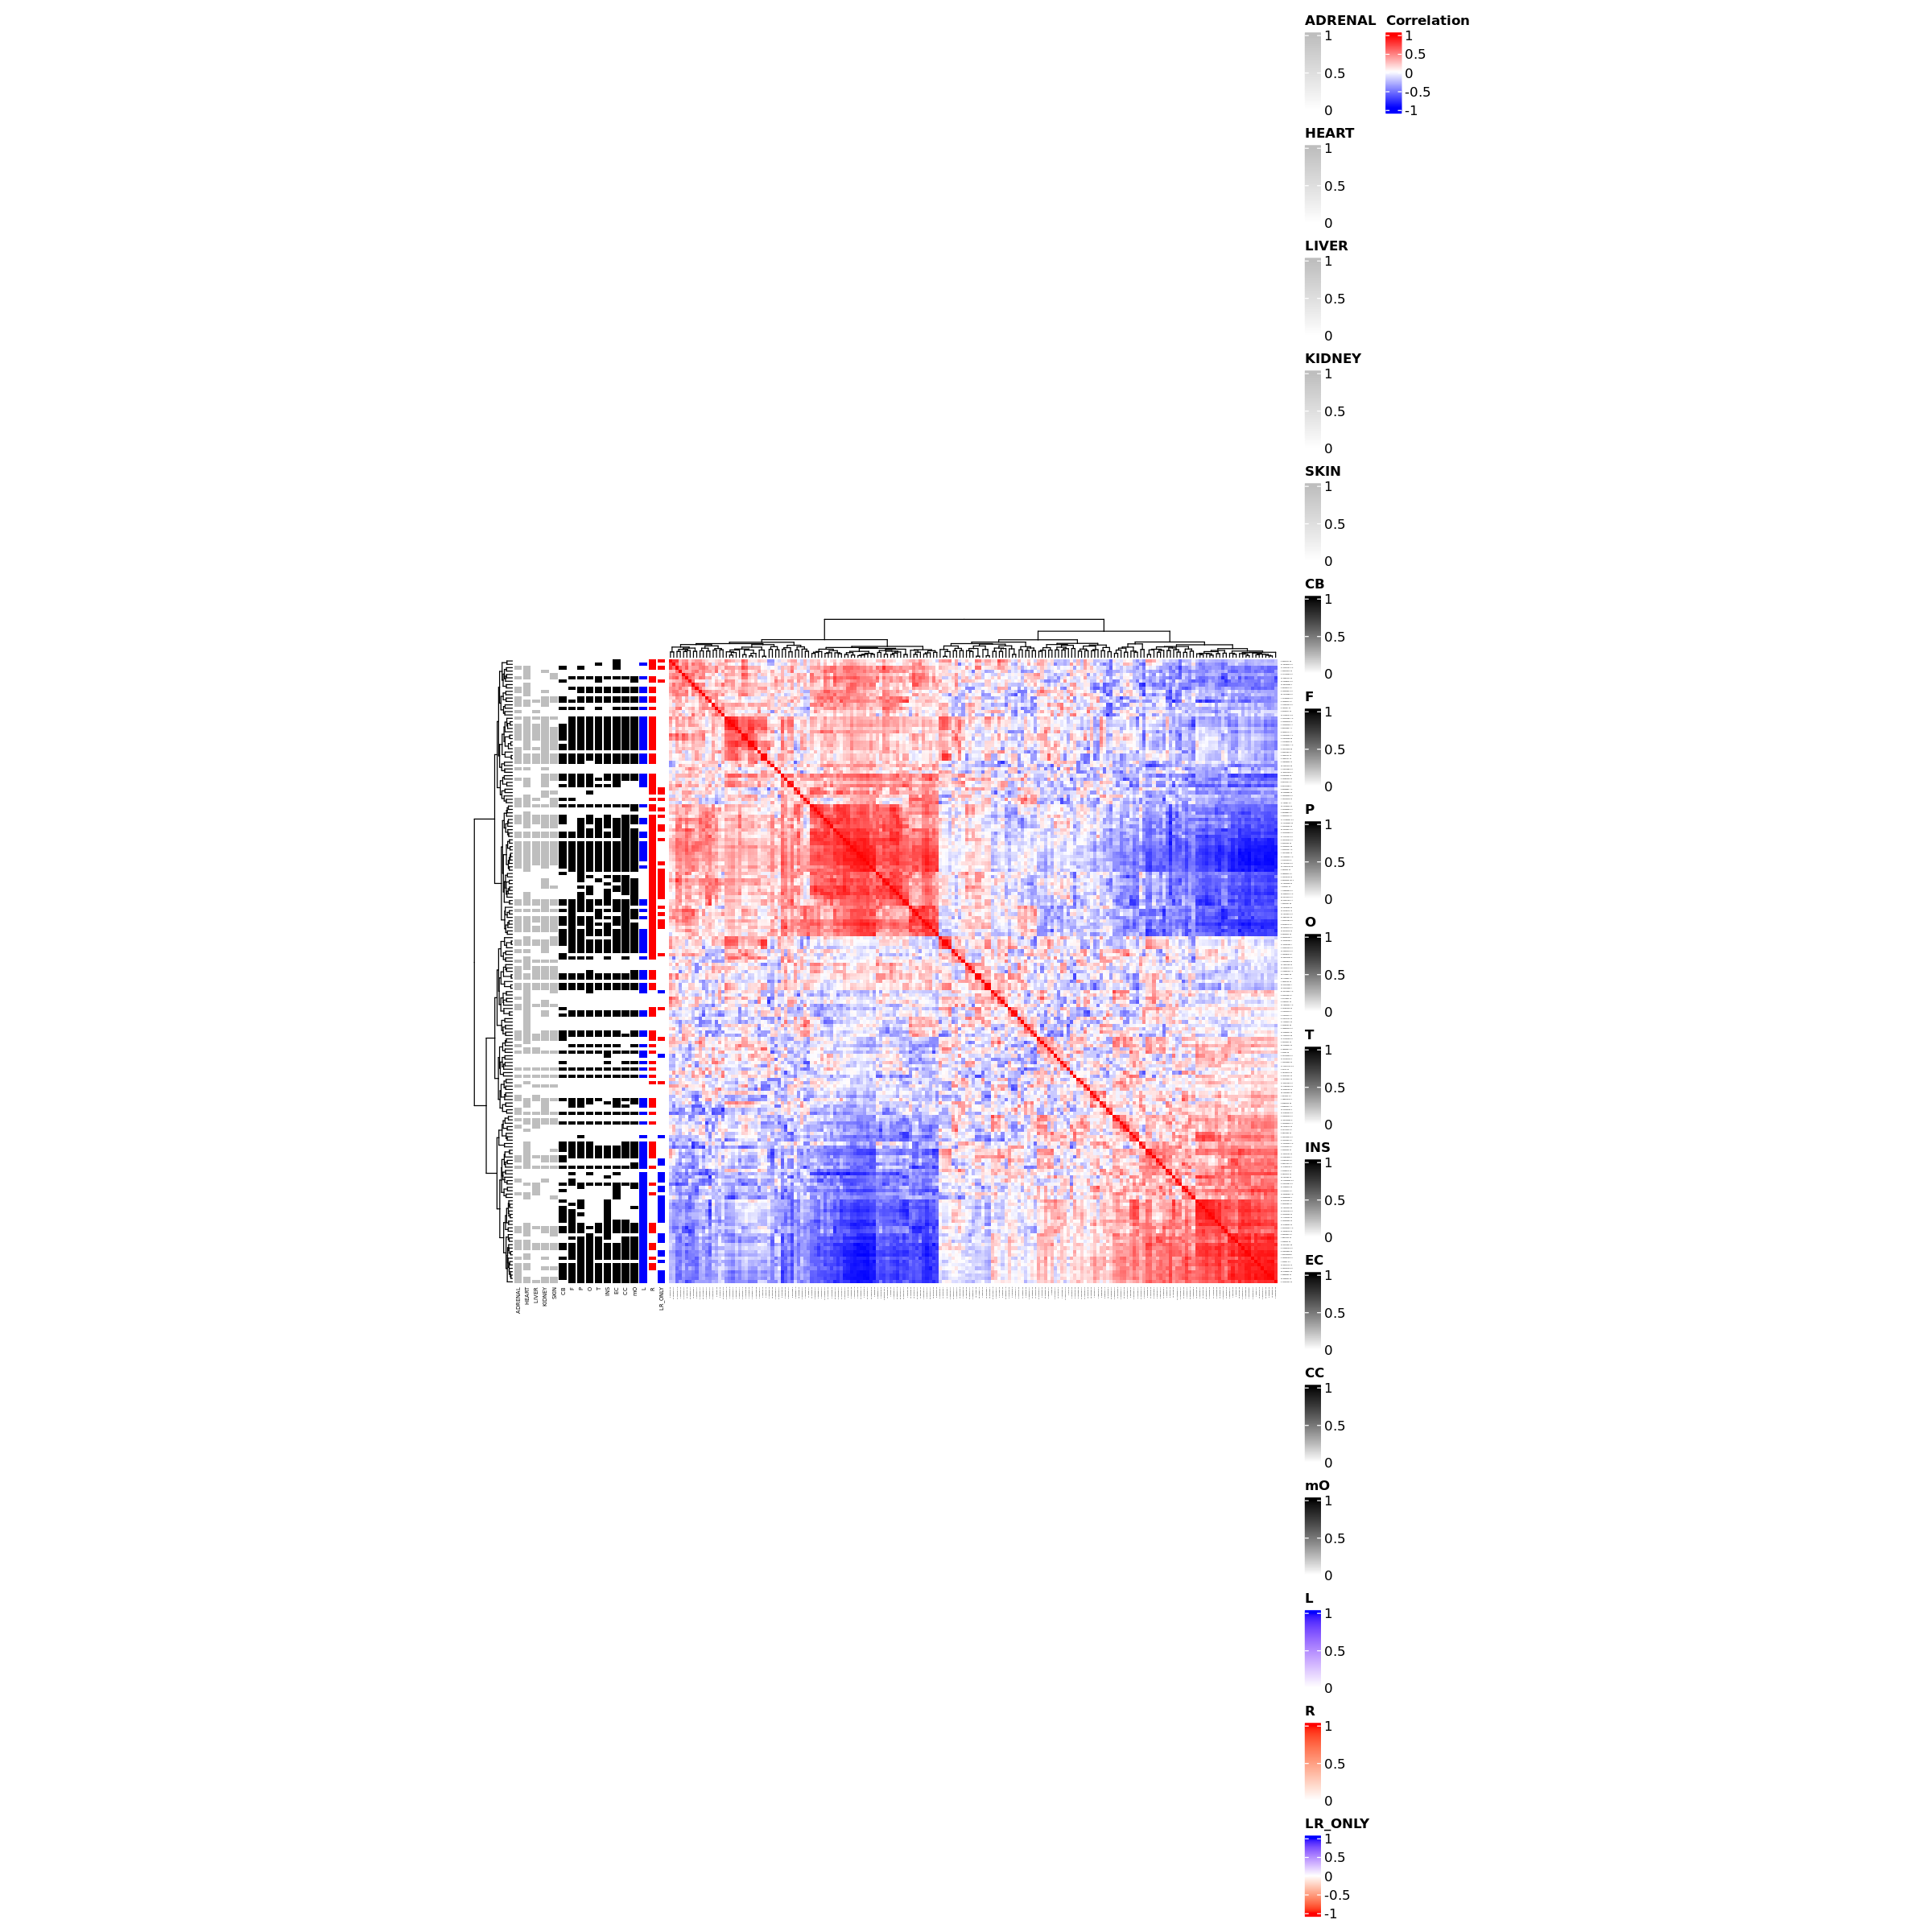

In [198]:
options(repr.plot.width=20, repr.plot.height=20)

complexheatmap <- Heatmap(df1_cor,
        col = Colors,
        row_names_gp = gpar(fontsize = "1"), column_names_gp = gpar(fontsize = "1"), name = "Correlation",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(16, "cm"),
        heatmap_height = unit(18, "cm")) 
complexheatmap

In [199]:
pdf(file="../VarXVar_plots/7669_VarByVar_COUPTF2_184_shared_Var.pdf",width=40,height=40)
complexheatmap
dev.off()

png 
  2

# TBR1

In [19]:
filtered$Punch<-as.character(filtered$Punch)
filtered$Note<-as.character(filtered$Note)

In [20]:
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] 
shared_variant_list<-variant_list[variant_list$sample_number_presented>1,]
shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(shared_variant_list),]

In [21]:
# taking a subset of samples
melt_mtcars<-shared_mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region","Bulk_main", "Sort_main","CTX_BG_HIP_relationship", "Cell_Type","Note")]
melt_mtcars<-melt_mtcars[melt_mtcars$Sort_main==1,]
melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('TBR1'),]
melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX')),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)
nrow(melt_mtcars)

[1] 2418

In [22]:
#dcasting with labeling
casted_MAF_VarBySample <- dcast(melt_mtcars, ID~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID # change rownames to ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1] # remove ID column
nrow(casted_MAF_VarBySample2) # row number 

[1] 13

In [23]:
#remove labeling from dcasted matrix
casted_MAF_VarBySample3<-na.omit(t(casted_MAF_VarBySample2)) # Sample by variant matrix with sqrt-MAF values
var_anno<-variant_list[variant_list$variant_list %in% rownames(casted_MAF_VarBySample3),] # take variant annotation from the variants in casted_MAF_VarBySample3
casted_MAF_VarBySample3<-casted_MAF_VarBySample3[order(rownames(casted_MAF_VarBySample3)), ] # rearrange the casted_MAF_VarBySample3 matrix in order of variant name
var_anno<-var_anno[order(row.names(var_anno)), ] # rearrange the var_anno in order of variant name
casted_MAF_VarBySample3 <- cbind(casted_MAF_VarBySample3,var_anno)

In [24]:
label<-casted_MAF_VarBySample3[which(names(casted_MAF_VarBySample3)=='variant_list'):ncol(casted_MAF_VarBySample3)]

In [25]:
df1<-casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)]
print(paste("nrows before filtering :",nrow(df1)))
# Remove variants with zero values in all samples
all_zero_row_in_df1<-df1[rowSums(df1 != 0) == 0, ]
label<-label[!label$variant_list %in% rownames(all_zero_row_in_df1),]
df1<-df1[rowSums(df1 != 0) > 0, ]
df1_cor<-cor(t(df1),method = "pearson")
print(paste("removed rows due to zero values in all column :",nrow(all_zero_row_in_df1)))
print(paste("remaining rows :",nrow(df1)))
myCol<-as.data.frame(label[,])

[1] "nrows before filtering : 186"
[1] "removed rows due to zero values in all column : 1"
[1] "remaining rows : 185"


In [26]:
LR_colors = colorRamp2(c(-1, 0, 1), c("#d68426", "#ffffff", "#2a1abf"))
Colors = c("blue","white","red")
Colors = colorRampPalette(Colors)(100)

In [27]:
names(myCol)

[1] "variant_list"                    "sample_number_presented"        
  [3] "HEART"                           "ADRENAL"                        
  [5] "CB"                              "CTX"                            
  [7] "LIVER"                           "KIDNEY"                         
  [9] "POA"                             "BG"                             
 [11] "THAL"                            "SKIN"                           
 [13] "OLF"                             "HIP"                            
 [15] "L"                               "R"                              
 [17] "I"                               "F"                              
 [19] "P"                               "O"                              
 [21] "T"                               "Cau"                            
 [23] "Put"                             "Thal"                           
 [25] "GP"                              "Hip"                            
 [27] "EC"                              "Olf"                            
 [29] "CC"                              "mO"                             
 [31] "Cb"                              "DLX1"                           
 [33] "TBR1"                            "COUPTF2"                        
 [35] "Bulk"                            "NeuN"                           
 [37] "Brain_only"                      "CTX_only"                       
 [39] "BG_only"                         "THAL_only"                      
 [41] "CTX_BG_only"                     "CTX_BG_shared"                  
 [43] "CTX_THAL_shared"                 "Left_only"                      
 [45] "Right_only"                      "sample_number_presented_COUPTF2"
 [47] "HEART_COUPTF2"                   "ADRENAL_COUPTF2"                
 [49] "CB_COUPTF2"                      "CTX_COUPTF2"                    
 [51] "LIVER_COUPTF2"                   "KIDNEY_COUPTF2"                 
 [53] "POA_COUPTF2"                     "BG_COUPTF2"                     
 [55] "THAL_COUPTF2"                    "SKIN_COUPTF2"                   
 [57] "OLF_COUPTF2"                     "HIP_COUPTF2"                    
 [59] "L_COUPTF2"                       "R_COUPTF2"                      
 [61] "I_COUPTF2"                       "F_COUPTF2"                      
 [63] "P_COUPTF2"                       "O_COUPTF2"                      
 [65] "T_COUPTF2"                       "Cau_COUPTF2"                    
 [67] "Put_COUPTF2"                     "Thal_COUPTF2"                   
 [69] "GP_COUPTF2"                      "Hip_COUPTF2"                    
 [71] "EC_COUPTF2"                      "Olf_COUPTF2"                    
 [73] "CC_COUPTF2"                      "mO_COUPTF2"                     
 [75] "Cb_COUPTF2"                      "DLX1_COUPTF2"                   
 [77] "TBR1_COUPTF2"                    "COUPTF2_COUPTF2"                
 [79] "Bulk_COUPTF2"                    "NeuN_COUPTF2"                   
 [81] "Brain_only_COUPTF2"              "CTX_only_COUPTF2"               
 [83] "BG_only_COUPTF2"                 "THAL_only_COUPTF2"              
 [85] "CTX_BG_only_COUPTF2"             "CTX_BG_shared_COUPTF2"          
 [87] "CTX_THAL_shared_COUPTF2"         "Left_only_COUPTF2"              
 [89] "Right_only_COUPTF2"              "IN_only_COUPTF2"                
 [91] "COUP_only_COUPTF2"               "TBR_only_COUPTF2"               
 [93] "TBR_BR_COUPTF2"                  "DLX_BR_COUPTF2"                 
 [95] "sample_number_presented_TBR1"    "CTX_TBR1"                       
 [97] "HIP_TBR1"                        "L_TBR1"                         
 [99] "R_TBR1"                          "I_TBR1"                         
[101] "F_TBR1"                          "P_TBR1"                         
[103] "O_TBR1"                          "T_TBR1"                         
[105] "Hip_TBR1"                        "CTX_only_TBR1"                  
[107] "HIP_only_TBR1"                   "Left_only_TBR1"                 
[109] 

In [28]:
LR_colors = colorRamp2(c(-1, 0, 1), c("#FF0000", "#ffffff", "#0000FF"))
color_list = list(LR_ONLY = LR_colors,
                  HEART = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  LIVER = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  KIDNEY = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  ADRENAL = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  SKIN = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  CTX = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  POA = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  BG = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  THAL = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  HIP = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  OLF = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CB = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  PF = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  F = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  P = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  O = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  T = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  INS = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  EC = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CC = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  mO = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  L = colorRamp2(c(0, 1), c("#ffffff", "#0000FF")),
                  R = colorRamp2(c(0, 1), c("#ffffff", "#FF0000")))

left_right_cell_col_ann = HeatmapAnnotation(simple_anno_size = unit(0.2, "cm"), 
                                        which = "row", 
                                        annotation_name_gp = gpar(fontsize = 4),
                                        ADRENAL = myCol$ADRENAL,
                                        HEART = myCol$HEART,
                                        LIVER = myCol$LIVER,
                                        KIDNEY = myCol$KIDNEY,
                                        SKIN = myCol$SKIN,
                                        CB = myCol$CB,
                                        F = myCol$F_TBR1,
                                        P = myCol$P_TBR1,
                                        O = myCol$O_TBR1,
                                        T = myCol$T_TBR1,
                                        INS = myCol$I_TBR1,
                                        EC = myCol$EC_TBR1,
                                        CC = myCol$CC_TBR1,
                                        mO = myCol$mO_TBR1,
                                        L = myCol$L_TBR1,
                                        R = myCol$R_TBR1,
                                        LR_ONLY = myCol$Left_only_TBR1 - myCol$Right_only_TBR1,
                                        col = color_list
                                        )

In [29]:
left_right_cell_col_ann

A HeatmapAnnotation object with 14 annotations
  name: heatmap_annotation_1 
  position: row 
  items: 185 
  width: 32.5689774456898mm 
  height: 1npc 
  this object is subsettable
  7.66467777777778mm extension on the bottom 

    name   annotation_type color_mapping width
 ADRENAL continuous vector  user-defined   2mm
   HEART continuous vector  user-defined   2mm
   LIVER continuous vector  user-defined   2mm
  KIDNEY continuous vector  user-defined   2mm
    SKIN continuous vector  user-defined   2mm
      CB continuous vector  user-defined   2mm
       F continuous vector  user-defined   2mm
       P continuous vector  user-defined   2mm
       O continuous vector  user-defined   2mm
       T continuous vector  user-defined   2mm
     INS continuous vector  user-defined   2mm
       L continuous vector  user-defined   2mm
       R continuous vector  user-defined   2mm
 LR_ONLY continuous vector  user-defined   2mm

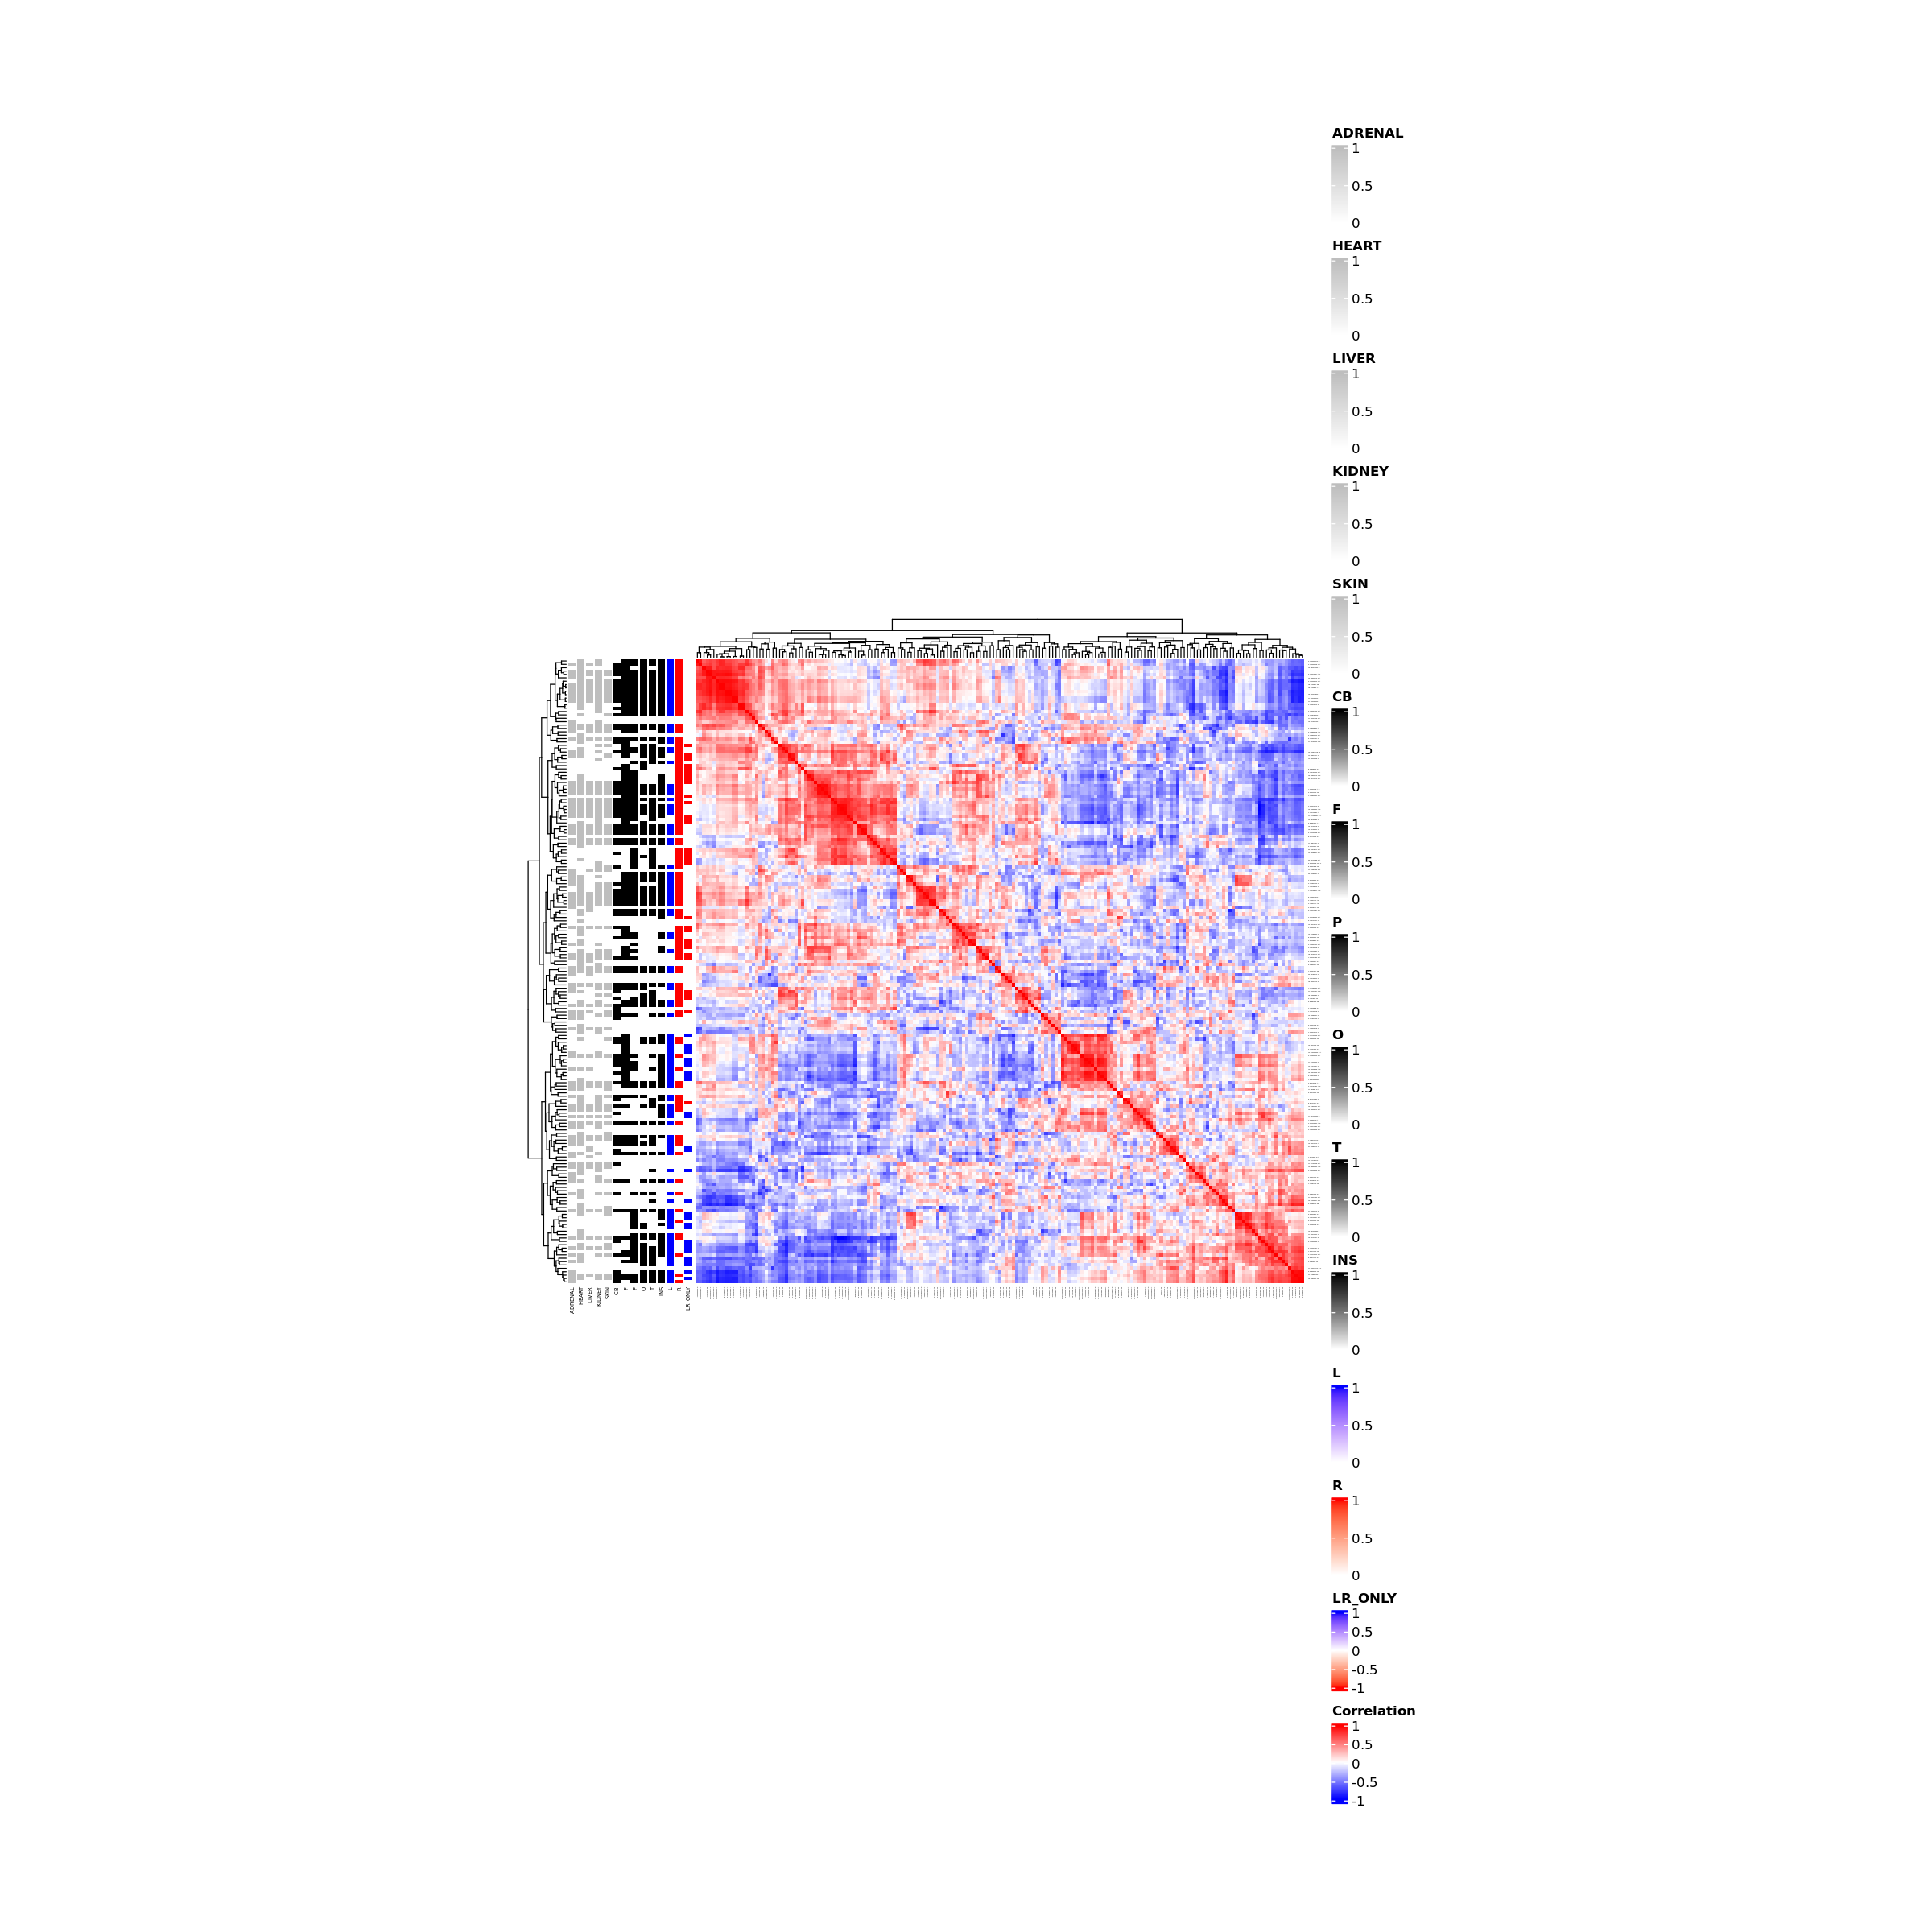

In [30]:
options(repr.plot.width=20, repr.plot.height=20)

complexheatmap <- Heatmap(df1_cor,
        col = Colors,
        row_names_gp = gpar(fontsize = "1"), column_names_gp = gpar(fontsize = "1"), name = "Correlation",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(16, "cm"),
        heatmap_height = unit(18, "cm")) 
complexheatmap

In [31]:
pdf(file="../VarXVar_plots/7669_VarByVar_TBR1_184_shared_Var.pdf",width=40,height=40)
complexheatmap
dev.off()

png 
  2

# DLX1

In [32]:
filtered$Punch<-as.character(filtered$Punch)
filtered$Note<-as.character(filtered$Note)

In [33]:
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] 
shared_variant_list<-variant_list[variant_list$sample_number_presented>1,]
shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(shared_variant_list),]

In [34]:
# taking a subset of samples
melt_mtcars<-shared_mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region","Bulk_main", "Sort_main","CTX_BG_HIP_relationship", "Cell_Type","Note")]
melt_mtcars<-melt_mtcars[melt_mtcars$Sort_main==1,]
melt_mtcars<-melt_mtcars[melt_mtcars$Cell_Type %in% c('DLX1'),]
melt_mtcars<-melt_mtcars[(melt_mtcars$Organ %in% c('CTX')),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)
nrow(melt_mtcars)

[1] 2976

In [35]:
#dcasting with labeling
casted_MAF_VarBySample <- dcast(melt_mtcars, ID~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID # change rownames to ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1] # remove ID column
nrow(casted_MAF_VarBySample2) # row number 

[1] 16

In [36]:
#remove labeling from dcasted matrix
casted_MAF_VarBySample3<-na.omit(t(casted_MAF_VarBySample2)) # Sample by variant matrix with sqrt-MAF values
var_anno<-variant_list[variant_list$variant_list %in% rownames(casted_MAF_VarBySample3),] # take variant annotation from the variants in casted_MAF_VarBySample3
casted_MAF_VarBySample3<-casted_MAF_VarBySample3[order(rownames(casted_MAF_VarBySample3)), ] # rearrange the casted_MAF_VarBySample3 matrix in order of variant name
var_anno<-var_anno[order(row.names(var_anno)), ] # rearrange the var_anno in order of variant name
casted_MAF_VarBySample3 <- cbind(casted_MAF_VarBySample3,var_anno)

In [37]:
label<-casted_MAF_VarBySample3[which(names(casted_MAF_VarBySample3)=='variant_list'):ncol(casted_MAF_VarBySample3)]

In [38]:
df1<-casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)]
print(paste("nrows before filtering :",nrow(df1)))
# Remove variants with zero values in all samples
all_zero_row_in_df1<-df1[rowSums(df1 != 0) == 0, ]
label<-label[!label$variant_list %in% rownames(all_zero_row_in_df1),]
df1<-df1[rowSums(df1 != 0) > 0, ]
df1_cor<-cor(t(df1),method = "pearson")
print(paste("removed rows due to zero values in all column :",nrow(all_zero_row_in_df1)))
print(paste("remaining rows :",nrow(df1)))
myCol<-as.data.frame(label[,])

[1] "nrows before filtering : 186"
[1] "removed rows due to zero values in all column : 1"
[1] "remaining rows : 185"


In [39]:
LR_colors = colorRamp2(c(-1, 0, 1), c("#d68426", "#ffffff", "#2a1abf"))
Colors = c("blue","white","red")
Colors = colorRampPalette(Colors)(100)

In [40]:
names(myCol)

[1] "variant_list"                    "sample_number_presented"        
  [3] "HEART"                           "ADRENAL"                        
  [5] "CB"                              "CTX"                            
  [7] "LIVER"                           "KIDNEY"                         
  [9] "POA"                             "BG"                             
 [11] "THAL"                            "SKIN"                           
 [13] "OLF"                             "HIP"                            
 [15] "L"                               "R"                              
 [17] "I"                               "F"                              
 [19] "P"                               "O"                              
 [21] "T"                               "Cau"                            
 [23] "Put"                             "Thal"                           
 [25] "GP"                              "Hip"                            
 [27] "EC"                              "Olf"                            
 [29] "CC"                              "mO"                             
 [31] "Cb"                              "DLX1"                           
 [33] "TBR1"                            "COUPTF2"                        
 [35] "Bulk"                            "NeuN"                           
 [37] "Brain_only"                      "CTX_only"                       
 [39] "BG_only"                         "THAL_only"                      
 [41] "CTX_BG_only"                     "CTX_BG_shared"                  
 [43] "CTX_THAL_shared"                 "Left_only"                      
 [45] "Right_only"                      "sample_number_presented_COUPTF2"
 [47] "HEART_COUPTF2"                   "ADRENAL_COUPTF2"                
 [49] "CB_COUPTF2"                      "CTX_COUPTF2"                    
 [51] "LIVER_COUPTF2"                   "KIDNEY_COUPTF2"                 
 [53] "POA_COUPTF2"                     "BG_COUPTF2"                     
 [55] "THAL_COUPTF2"                    "SKIN_COUPTF2"                   
 [57] "OLF_COUPTF2"                     "HIP_COUPTF2"                    
 [59] "L_COUPTF2"                       "R_COUPTF2"                      
 [61] "I_COUPTF2"                       "F_COUPTF2"                      
 [63] "P_COUPTF2"                       "O_COUPTF2"                      
 [65] "T_COUPTF2"                       "Cau_COUPTF2"                    
 [67] "Put_COUPTF2"                     "Thal_COUPTF2"                   
 [69] "GP_COUPTF2"                      "Hip_COUPTF2"                    
 [71] "EC_COUPTF2"                      "Olf_COUPTF2"                    
 [73] "CC_COUPTF2"                      "mO_COUPTF2"                     
 [75] "Cb_COUPTF2"                      "DLX1_COUPTF2"                   
 [77] "TBR1_COUPTF2"                    "COUPTF2_COUPTF2"                
 [79] "Bulk_COUPTF2"                    "NeuN_COUPTF2"                   
 [81] "Brain_only_COUPTF2"              "CTX_only_COUPTF2"               
 [83] "BG_only_COUPTF2"                 "THAL_only_COUPTF2"              
 [85] "CTX_BG_only_COUPTF2"             "CTX_BG_shared_COUPTF2"          
 [87] "CTX_THAL_shared_COUPTF2"         "Left_only_COUPTF2"              
 [89] "Right_only_COUPTF2"              "IN_only_COUPTF2"                
 [91] "COUP_only_COUPTF2"               "TBR_only_COUPTF2"               
 [93] "TBR_BR_COUPTF2"                  "DLX_BR_COUPTF2"                 
 [95] "sample_number_presented_TBR1"    "CTX_TBR1"                       
 [97] "HIP_TBR1"                        "L_TBR1"                         
 [99] "R_TBR1"                          "I_TBR1"                         
[101] "F_TBR1"                          "P_TBR1"                         
[103] "O_TBR1"                          "T_TBR1"                         
[105] "Hip_TBR1"                        "CTX_only_TBR1"                  
[107] "HIP_only_TBR1"                   "Left_only_TBR1"                 
[109] 

In [41]:
LR_colors = colorRamp2(c(-1, 0, 1), c("#FF0000", "#ffffff", "#0000FF"))
color_list = list(LR_ONLY = LR_colors,
                  HEART = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  LIVER = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  KIDNEY = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  ADRENAL = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  SKIN = colorRamp2(c(0, 1), c("#ffffff", "grey")),
                  CTX = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  POA = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  BG = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  THAL = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  HIP = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  OLF = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CB = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  PF = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  F = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  P = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  O = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  T = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  INS = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  EC = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  CC = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  mO = colorRamp2(c(0, 1), c("#ffffff", "black")),
                  L = colorRamp2(c(0, 1), c("#ffffff", "#0000FF")),
                  R = colorRamp2(c(0, 1), c("#ffffff", "#FF0000")))

left_right_cell_col_ann = HeatmapAnnotation(simple_anno_size = unit(0.2, "cm"), 
                                        which = "row", 
                                        annotation_name_gp = gpar(fontsize = 4),
                                        ADRENAL = myCol$ADRENAL,
                                        HEART = myCol$HEART,
                                        LIVER = myCol$LIVER,
                                        KIDNEY = myCol$KIDNEY,
                                        SKIN = myCol$SKIN,
                                        CB = myCol$CB,
                                        F = myCol$F_DLX1,
                                        P = myCol$P_DLX1,
                                        O = myCol$O_DLX1,
                                        T = myCol$T_DLX1,
                                        INS = myCol$I_DLX1,
                                        EC = myCol$EC_DLX1,
                                        CC = myCol$CC_DLX1,
                                        mO = myCol$mO_DLX1,
                                        L = myCol$L_DLX1,
                                        R = myCol$R_DLX1,
                                        LR_ONLY = myCol$Left_only_DLX1 - myCol$Right_only_DLX1,
                                        col = color_list
                                        )

In [42]:
left_right_cell_col_ann

A HeatmapAnnotation object with 14 annotations
  name: heatmap_annotation_2 
  position: row 
  items: 185 
  width: 32.5689774456898mm 
  height: 1npc 
  this object is subsettable
  7.66467777777778mm extension on the bottom 

    name   annotation_type color_mapping width
 ADRENAL continuous vector  user-defined   2mm
   HEART continuous vector  user-defined   2mm
   LIVER continuous vector  user-defined   2mm
  KIDNEY continuous vector  user-defined   2mm
    SKIN continuous vector  user-defined   2mm
      CB continuous vector  user-defined   2mm
       F continuous vector  user-defined   2mm
       P continuous vector  user-defined   2mm
       O continuous vector  user-defined   2mm
       T continuous vector  user-defined   2mm
     INS continuous vector  user-defined   2mm
       L continuous vector  user-defined   2mm
       R continuous vector  user-defined   2mm
 LR_ONLY continuous vector  user-defined   2mm

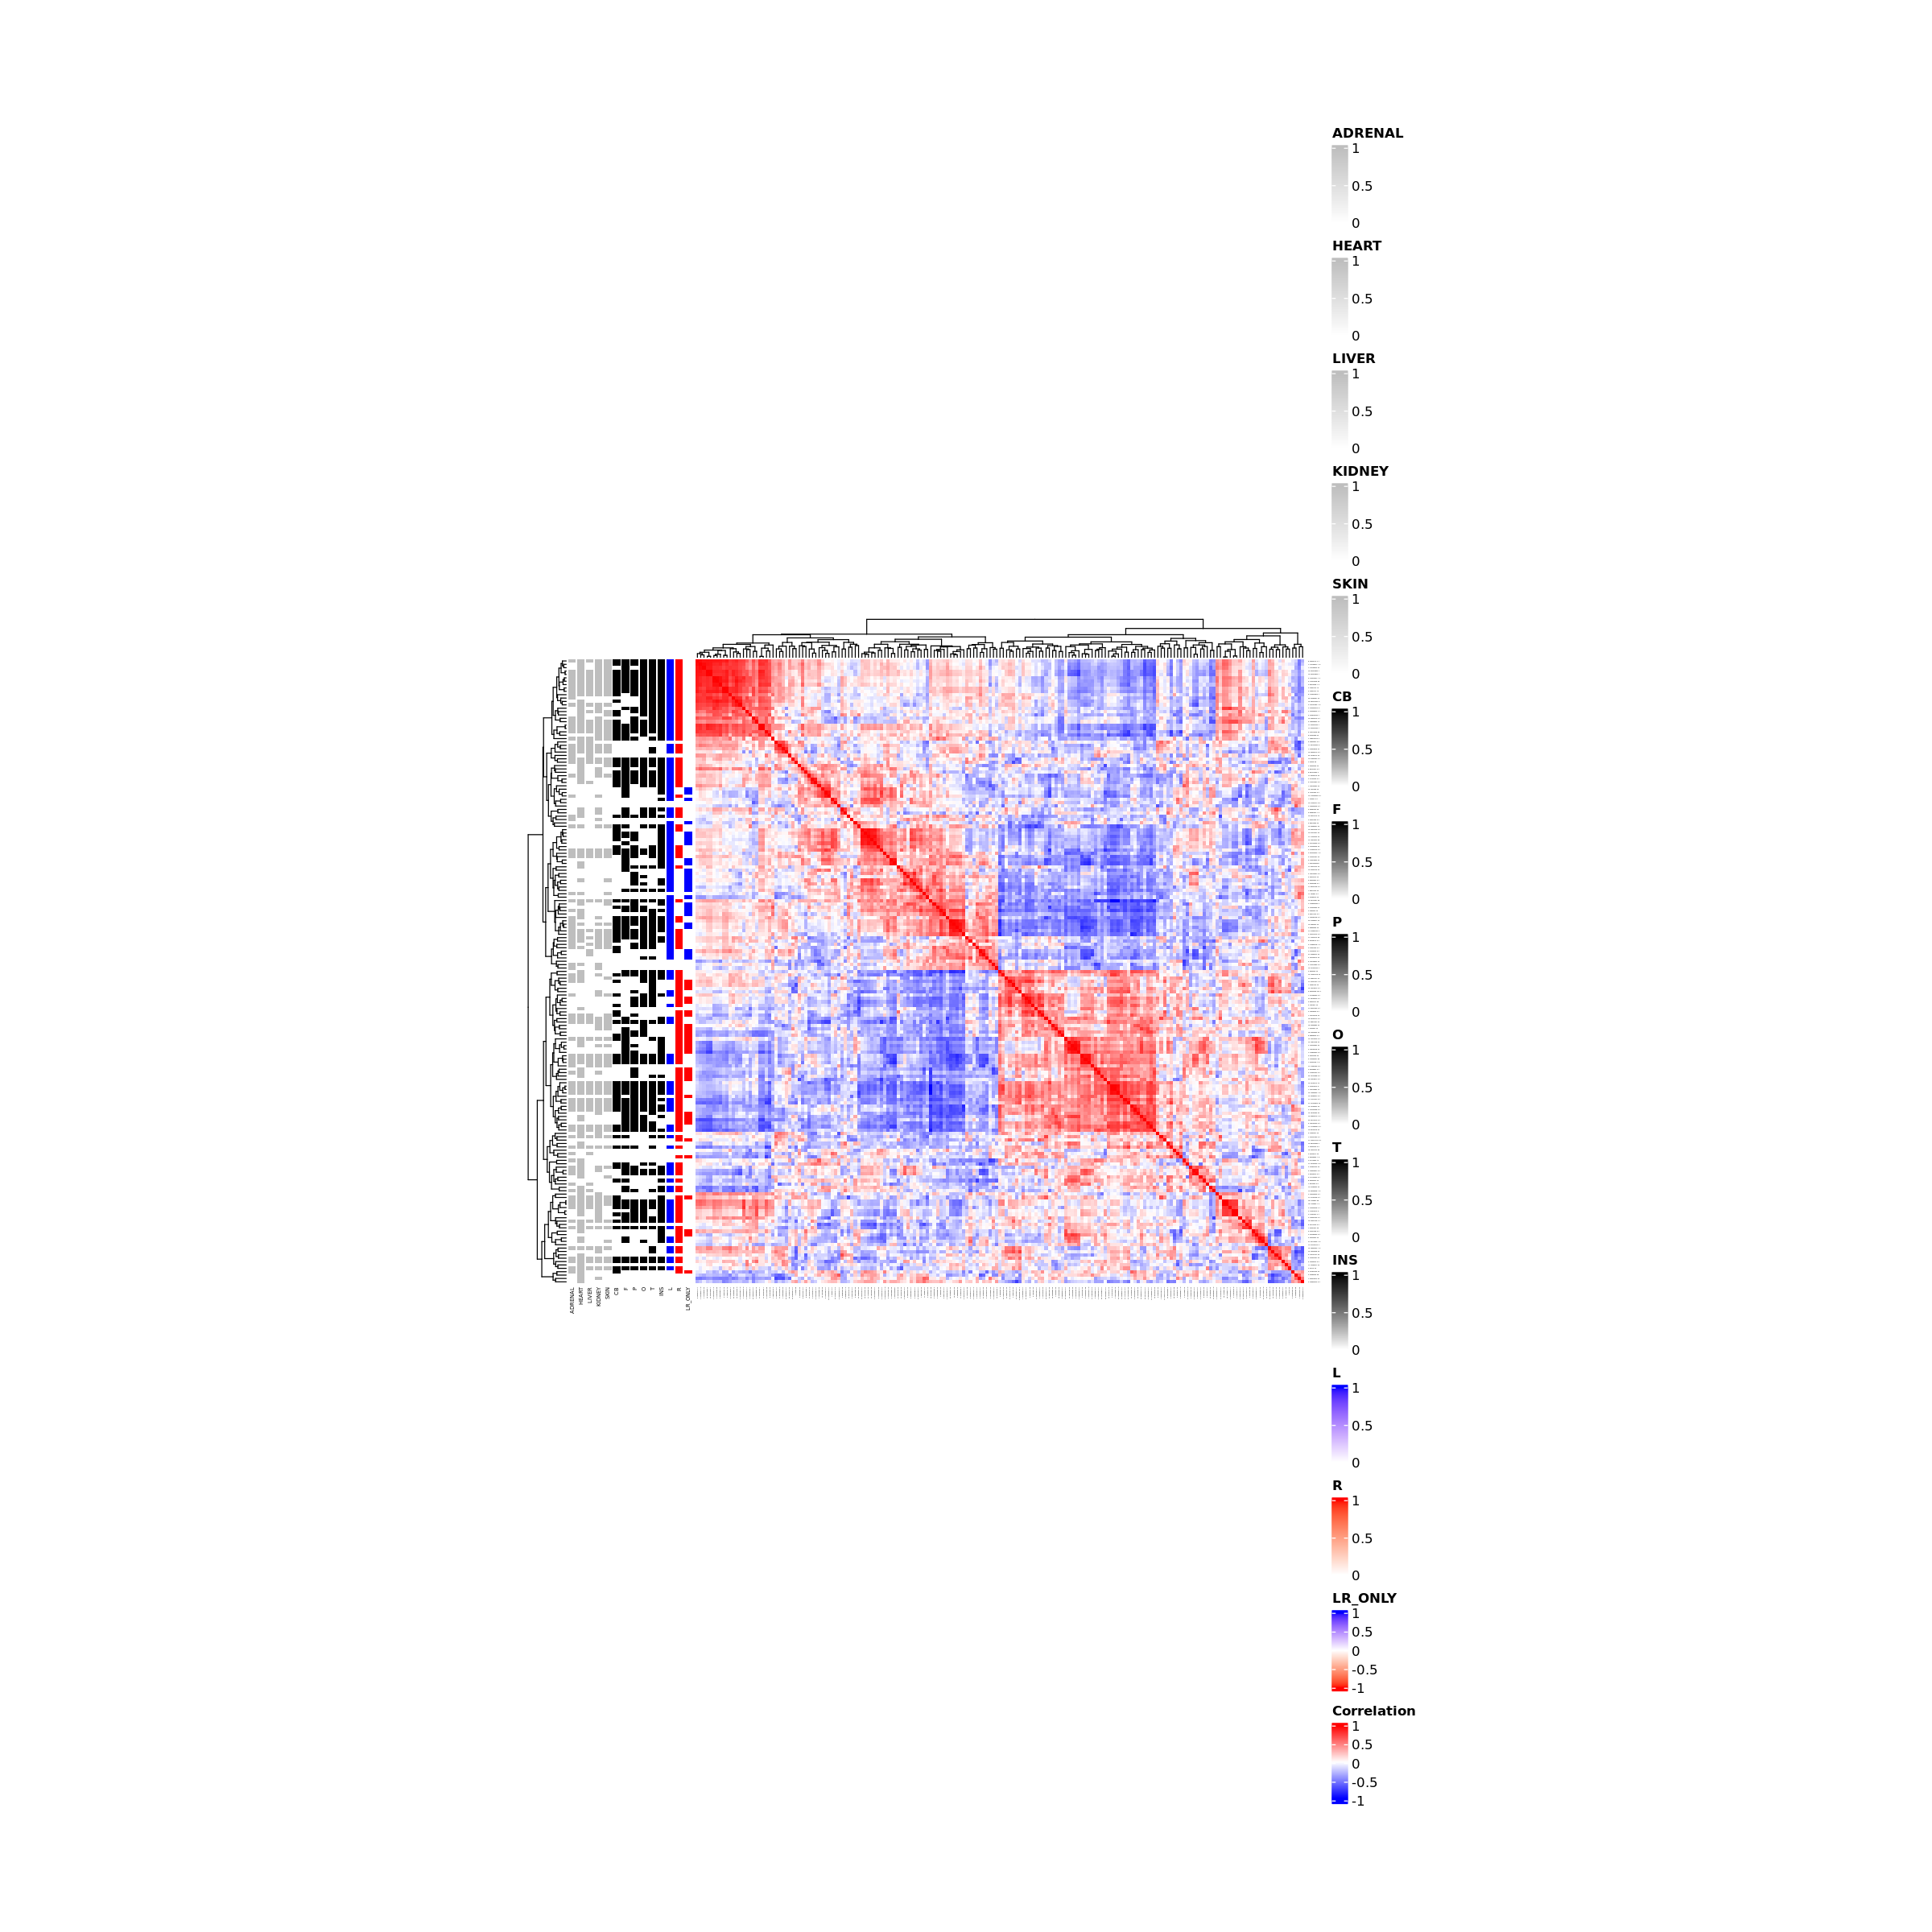

In [43]:
options(repr.plot.width=20, repr.plot.height=20)

complexheatmap <- Heatmap(df1_cor,
        col = Colors,
        row_names_gp = gpar(fontsize = "1"), column_names_gp = gpar(fontsize = "1"), name = "Correlation",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(16, "cm"),
        heatmap_height = unit(18, "cm")) 
complexheatmap

In [44]:
pdf(file="../VarXVar_plots/7669_VarByVar_DLX1_185_shared_Var.pdf",width=40,height=40)
complexheatmap
dev.off()

png 
  2

# CBH

In [26]:
filtered$Punch<-as.character(filtered$Punch)
filtered$Note<-as.character(filtered$Note)
mosaic_filtered <- filtered[filtered$Mosaic_shared_btw_WGS_Amp==1,] #Use 269 variants. assign this to mosaic_filtered
shared_variant_list<-variant_list[variant_list$sample_number_presented_CBH>1,]
shared_mosaic_filtered<-mosaic_filtered[mosaic_filtered$CHROM.POS.REF.ALT %in% rownames(shared_variant_list),]
#mosaic_filtered[is.na(mosaic_filtered$Punch),]$Punch <-'1000'

In [27]:
melt_mtcars<-mosaic_filtered[,c("ID", "CHROM.POS.REF.ALT", "MAF", "Hemisphere", "Organ", "Region", "Cell_Type", "CTX_BG_HIP_relationship")]
melt_mtcars<-na.omit(melt_mtcars[melt_mtcars$CHROM.POS.REF.ALT %in% shared_variant_list$variant_list,])

In [28]:
melt_mtcars<-melt_mtcars[melt_mtcars$CTX_BG_HIP_relationship %in% c('1'),]
melt_mtcars$MAF <- sqrt(melt_mtcars$MAF)

In [29]:
colnames(melt_mtcars)

[1] "ID"                      "CHROM.POS.REF.ALT"      
[3] "MAF"                     "Hemisphere"             
[5] "Organ"                   "Region"                 
[7] "Cell_Type"               "CTX_BG_HIP_relationship"

In [30]:
casted_MAF_VarBySample <- dcast(melt_mtcars, ID+Hemisphere+Region+Organ+Cell_Type~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1]
nrow(casted_MAF_VarBySample2)
unique(casted_MAF_VarBySample2$Hemisphere)
unique(casted_MAF_VarBySample2$Organ)
unique(casted_MAF_VarBySample2$Region)
unique(casted_MAF_VarBySample2$Cell_Type)

[1] 12

[1] "R"

[1] "BG"  "CTX" "HIP"

[1] "Cau" "Put" "F"   "I"   "mO"  "O"   "P"   "GP"  "Hip" "T"

[1] "DLX1" "TBR1"

In [31]:
#dcasting with labeling
casted_MAF_VarBySample <- dcast(melt_mtcars, ID~CHROM.POS.REF.ALT, value.var = "MAF", rm.na=T)
rownames(casted_MAF_VarBySample) <- casted_MAF_VarBySample$ID # change rownames to ID
casted_MAF_VarBySample2 <- casted_MAF_VarBySample[,-1] # remove ID column
nrow(casted_MAF_VarBySample2) # row number 

[1] 12

In [32]:
#remove labeling from dcasted matrix
casted_MAF_VarBySample3<-na.omit(t(casted_MAF_VarBySample2)) # Sample by variant matrix with sqrt-MAF values
var_anno<-variant_list[variant_list$variant_list %in% rownames(casted_MAF_VarBySample3),] # take variant annotation from the variants in casted_MAF_VarBySample3
casted_MAF_VarBySample3<-casted_MAF_VarBySample3[order(rownames(casted_MAF_VarBySample3)), ] # rearrange the casted_MAF_VarBySample3 matrix in order of variant name
var_anno<-var_anno[order(row.names(var_anno)), ] # rearrange the var_anno in order of variant name
casted_MAF_VarBySample3 <- cbind(casted_MAF_VarBySample3,var_anno)

In [33]:
label<-casted_MAF_VarBySample3[which(names(casted_MAF_VarBySample3)=='variant_list'):ncol(casted_MAF_VarBySample3)]
#UMAP<-umap(casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)])

In [34]:
df1<-casted_MAF_VarBySample3[,1:(which(names(casted_MAF_VarBySample3)=='variant_list')-1)]
print(paste("nrows before filtering :",nrow(df1)))
# Remove variants with zero values in all samples
all_zero_row_in_df1<-df1[rowSums(df1 != 0) == 0, ]
label<-label[!label$variant_list %in% rownames(all_zero_row_in_df1),]
df1<-df1[rowSums(df1 != 0) > 0, ]
df1_cor<-cor(t(df1),method = "pearson")
print(paste("removed rows due to zero values in all column :",nrow(all_zero_row_in_df1)))
print(paste("remaining rows :",nrow(df1)))
myCol<-as.data.frame(label[,])

[1] "nrows before filtering : 115"
[1] "removed rows due to zero values in all column : 0"
[1] "remaining rows : 115"


In [35]:
colnames(myCol)

[1] "variant_list"                    "sample_number_presented"        
  [3] "HEART"                           "ADRENAL"                        
  [5] "CB"                              "CTX"                            
  [7] "LIVER"                           "KIDNEY"                         
  [9] "POA"                             "BG"                             
 [11] "THAL"                            "SKIN"                           
 [13] "OLF"                             "HIP"                            
 [15] "L"                               "R"                              
 [17] "I"                               "F"                              
 [19] "P"                               "O"                              
 [21] "T"                               "Cau"                            
 [23] "Put"                             "Thal"                           
 [25] "GP"                              "Hip"                            
 [27] "EC"                              "Olf"                            
 [29] "CC"                              "mO"                             
 [31] "Cb"                              "DLX1"                           
 [33] "TBR1"                            "COUPTF2"                        
 [35] "Bulk"                            "NeuN"                           
 [37] "Brain_only"                      "CTX_only"                       
 [39] "BG_only"                         "THAL_only"                      
 [41] "CTX_BG_only"                     "CTX_BG_shared"                  
 [43] "CTX_THAL_shared"                 "Left_only"                      
 [45] "Right_only"                      "sample_number_presented_COUPTF2"
 [47] "HEART_COUPTF2"                   "ADRENAL_COUPTF2"                
 [49] "CB_COUPTF2"                      "CTX_COUPTF2"                    
 [51] "LIVER_COUPTF2"                   "KIDNEY_COUPTF2"                 
 [53] "POA_COUPTF2"                     "BG_COUPTF2"                     
 [55] "THAL_COUPTF2"                    "SKIN_COUPTF2"                   
 [57] "OLF_COUPTF2"                     "HIP_COUPTF2"                    
 [59] "L_COUPTF2"                       "R_COUPTF2"                      
 [61] "I_COUPTF2"                       "F_COUPTF2"                      
 [63] "P_COUPTF2"                       "O_COUPTF2"                      
 [65] "T_COUPTF2"                       "Cau_COUPTF2"                    
 [67] "Put_COUPTF2"                     "Thal_COUPTF2"                   
 [69] "GP_COUPTF2"                      "Hip_COUPTF2"                    
 [71] "EC_COUPTF2"                      "Olf_COUPTF2"                    
 [73] "CC_COUPTF2"                      "mO_COUPTF2"                     
 [75] "Cb_COUPTF2"                      "DLX1_COUPTF2"                   
 [77] "TBR1_COUPTF2"                    "COUPTF2_COUPTF2"                
 [79] "Bulk_COUPTF2"                    "NeuN_COUPTF2"                   
 [81] "Brain_only_COUPTF2"              "CTX_only_COUPTF2"               
 [83] "BG_only_COUPTF2"                 "THAL_only_COUPTF2"              
 [85] "CTX_BG_only_COUPTF2"             "CTX_BG_shared_COUPTF2"          
 [87] "CTX_THAL_shared_COUPTF2"         "Left_only_COUPTF2"              
 [89] "Right_only_COUPTF2"              "IN_only_COUPTF2"                
 [91] "COUP_only_COUPTF2"               "TBR_only_COUPTF2"               
 [93] "TBR_BR_COUPTF2"                  "DLX_BR_COUPTF2"                 
 [95] "sample_number_presented_TBR1"    "CTX_TBR1"                       
 [97] "HIP_TBR1"                        "L_TBR1"                         
 [99] "R_TBR1"                          "I_TBR1"                         
[101] "F_TBR1"                          "P_TBR1"                         
[103] "O_TBR1"                          "T_TBR1"                         
[105] "Hip_TBR1"                        "CTX_only_TBR1"                  
[107] "HIP_only_TBR1"                   "Left_only_TBR1"                 
[109] 

In [40]:
color_list = list(
                CTX = colorRamp2(c(0, 1), c("#ffffff", "#00DF3D")),
                BG = colorRamp2(c(0, 1), c("#ffffff", "#CBDF00")),
                HIP = colorRamp2(c(0, 1), c("#ffffff", "#9200DF")), 
                CTX_BG_shared = colorRamp2(c(0, 1), c("#ffffff", "#DE7058")),
                HIP_BG_shared = colorRamp2(c(0, 1), c("#ffffff", "#A1E843")),
                CTX_HIP_shared = colorRamp2(c(0, 1), c("#ffffff", "#284EED")))

left_right_cell_col_ann = HeatmapAnnotation(simple_anno_size = unit(0.2, "cm"), 
                                        which = "row", 
                                        annotation_name_gp = gpar(fontsize = 4),
                                        CTX = myCol$CTX_CBH,
                                        BG = myCol$BG_CBH,
                                        HIP = myCol$HIP_CBH,
                                        CTX_BG_shared = myCol$CTX_BG_shared_CBH,
                                        HIP_BG_shared = myCol$BG_HIP_shared_CBH,
                                        CTX_HIP_shared = myCol$CTX_HIP_shared_CBH,
 
                                        col = color_list
                                    #    annotation_legend_param = legendDets
                                        )


In [38]:
left_right_cell_col_ann

A HeatmapAnnotation object with 9 annotations
  name: heatmap_annotation_4 
  position: row 
  items: 115 
  width: 20.8116784281168mm 
  height: 1npc 
  this object is subsettable
  13.6238mm extension on the bottom 

           name   annotation_type color_mapping width
        CTX_CBH continuous vector        random   2mm
         BG_CBH continuous vector        random   2mm
        HIP_CBH continuous vector        random   2mm
       CTX_only continuous vector        random   2mm
        BG_ONLY continuous vector        random   2mm
       HIP_ONLY   discrete vector        random   2mm
  CTX_BG_SHARED continuous vector        random   2mm
 CTX_HIP_SHARED continuous vector        random   2mm
  BG_HIP_SHARED   discrete vector        random   2mm

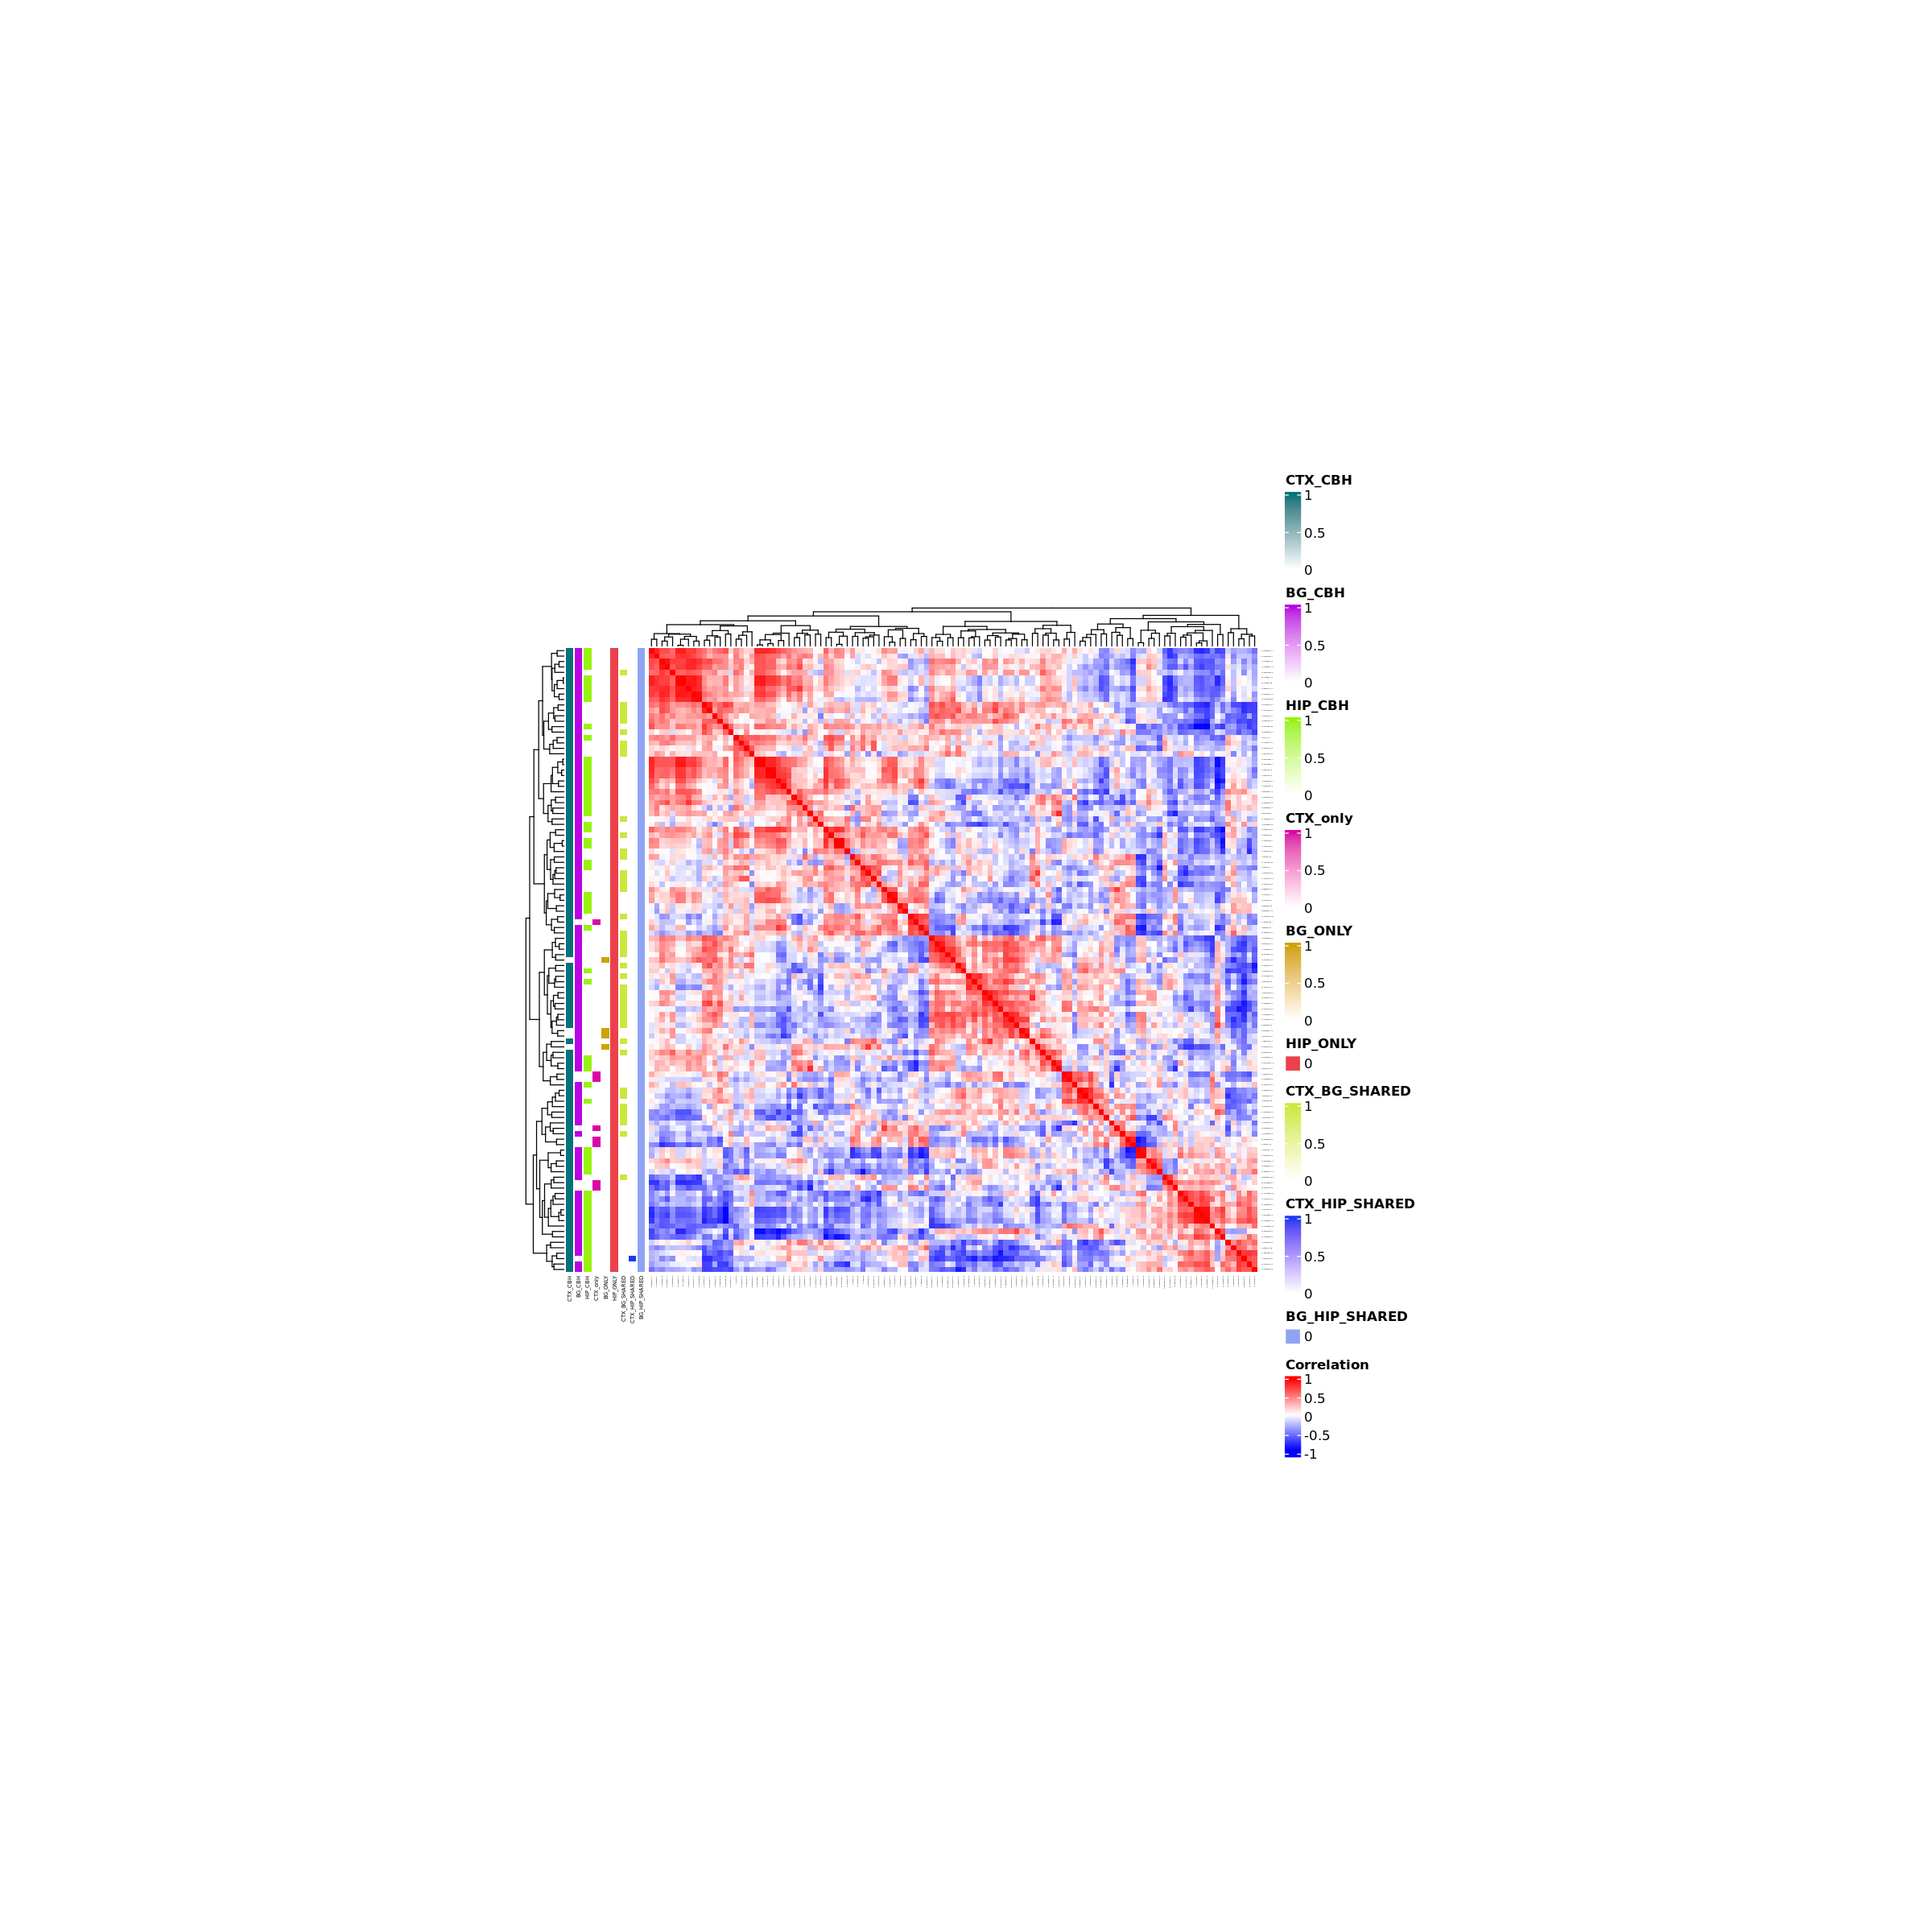

In [39]:
options(repr.plot.width=20, repr.plot.height=20)
Colors = c("blue","white","red")
Colors = colorRampPalette(Colors)(100)

complexheatmap <- Heatmap(df1_cor,
        col = Colors,
        row_names_gp = gpar(fontsize = "1"), column_names_gp = gpar(fontsize = "1"), name = "Correlation",
        left_annotation = left_right_cell_col_ann,
        clustering_method_rows = "complete", clustering_method_columns = "complete", 
        clustering_distance_rows = "manhattan", clustering_distance_columns = "manhattan",
        cluster_rows = TRUE, cluster_columns = TRUE,
        width = unit(16, "cm"),
        heatmap_height = unit(18, "cm")) 
complexheatmap

In [30]:
pdf(file="../VarXVar_plots/7669_VarByVar_CBH_115_shared_Var.pdf",width=40,height=40)
complexheatmap
dev.off()

png 
  2